# Redução de dimensionalidade com Autoencoder

## Importando as bibliotecas

In [21]:
#general
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
#autoencoder
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# Classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score

## Carregando os dados

In [22]:
# Fonte: https://www.kaggle.com/mattcarter865/sonar-mines-vs-rocks/data
sonar = pd.read_csv('./sonar.all-data.csv', header=None)

In [23]:
sonar

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M


In [24]:
sonar.groupby(60).size()

60
M    111
R     97
dtype: int64

## Padronização e divisão treino/teste

In [25]:
x = sonar.iloc[:,:-1]
y = sonar.iloc[:,-1]

sc = StandardScaler()
x_sc = sc.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Autoencoder: Redução de dimensionalidade

<img src="autoencoder.png">

In [26]:
#Arquitetura
class AutoEncoders(Model):

    def __init__(self, output_units):

        super().__init__()
        self.encoder = Sequential(
            [
              Dense(30, activation='relu', name="oculta_1"),
              Dense(20, activation='relu', name="oculta_2"),
              Dense(10, activation='relu', name="bottleneck"),
            ], name = 'output_encoder'
        )

        self.decoder = Sequential(
            [
              Dense(20, activation='relu', name="oculta_1"),
              Dense(30, activation='relu',  name="oculta_2"),
              Dense(output_units, activation="sigmoid")
            ], name = 'output_decoder'
        )

    def call(self, inputs):

      encoded = self.encoder(inputs)
      decoded = self.decoder(encoded)
      return decoded

In [27]:
# Treinamento
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

n_inputs = x_train.shape[1]
auto_encoder = AutoEncoders(n_inputs)

auto_encoder.compile(loss=losses.MeanSquaredError(), optimizer='adam')

callback_earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks_lr = LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 35))


#Observem aqui que ao invés de fitar (x,y), nós fitamos (x,x)
history = auto_encoder.fit(
    x_train, 
    x_train, 
    epochs=100, 
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, x_val),
    callbacks=[callback_earlystopping, callbacks_lr]
)

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

5/5 [==============================] - 0s 24ms/step - loss: 0.1270 - val_loss: 0.1237
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 0.1248 - val_loss: 0.1215
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.1222 - val_loss: 0.1180
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 0.1179 - val_loss: 0.1119
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1108 - val_loss: 0.1022
Epoch 6/100
5/5 [====

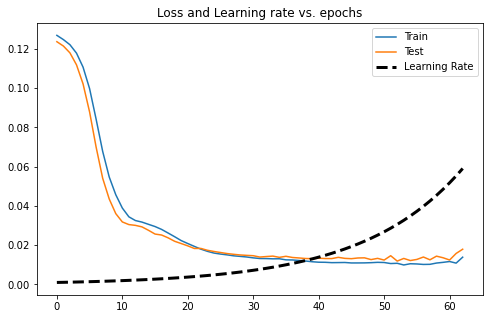

In [28]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.plot(history.history['lr'], label='Learning Rate', color='#000', lw=3, linestyle='--')
plt.legend()
plt.title('Loss and Learning rate vs. epochs')
plt.show()

In [29]:
auto_encoder.summary()

Model: "auto_encoders_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output_encoder (Sequential)  (None, 10)                2660      
_________________________________________________________________
output_decoder (Sequential)  (None, 60)                2710      
Total params: 5,370
Trainable params: 5,370
Non-trainable params: 0
_________________________________________________________________


In [32]:
auto_encoder.encoder.summary()

Model: "output_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
oculta_1 (Dense)             (None, 30)                1830      
_________________________________________________________________
oculta_2 (Dense)             (None, 20)                620       
_________________________________________________________________
bottleneck (Dense)           (None, 10)                210       
Total params: 2,660
Trainable params: 2,660
Non-trainable params: 0
_________________________________________________________________


In [43]:
w1 = auto_encoder.decoder.layers[0]

In [44]:
weights, bias = w1.get_weights()

In [45]:
print(weights.shape,bias.shape)

(10, 20) (20,)


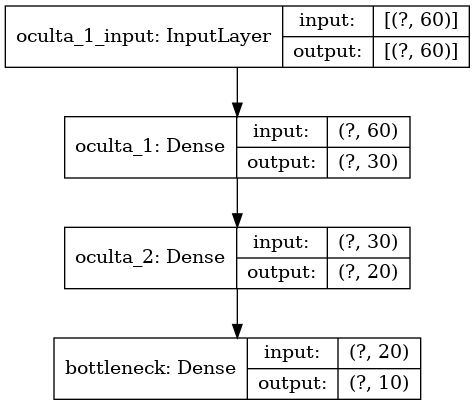

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(auto_encoder.encoder, 'encoder.png', show_shapes=True)

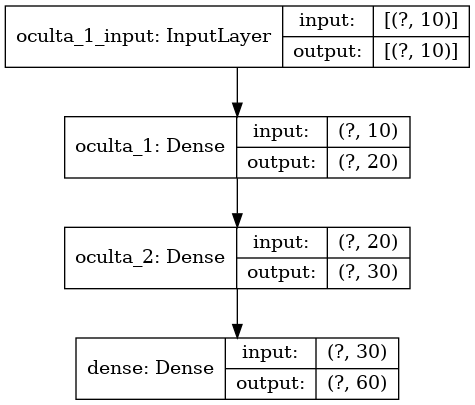

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(auto_encoder.decoder, 'decoder.png', show_shapes=True)

In [46]:
encoder_layer = auto_encoder.get_layer(name='output_encoder')
reduced_x_train = np.asarray(encoder_layer.predict(x_train))
reduced_x_test = np.asarray(encoder_layer.predict(x_test))
auto_encoder.get_layer('output_encoder').save('encoder.h5')

In [47]:
reduced_x_train.shape

(149, 10)

In [48]:
reduced_x_test.shape

(42, 10)

## Realizando a classifição com a dimensão reduzida 

In [49]:
def get_best_model(model_name, x, y):
    
    if model_name == 'lda':
        params = {'solver': ['svd', 'lsqr', 'eigen']}
        model = LinearDiscriminantAnalysis()
    elif model_name == 'knn':
        params = {'n_neighbors':[1,3,5,7,9,11,13,15,17,19,21]}
        model = KNeighborsClassifier()
    elif model_name == 'gbm':
        params = {'loss':["deviance","exponential"], 'max_features':["log2","sqrt"],'learning_rate': [0.01,0.05,0.1,0.5]}
        model = GradientBoostingClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    
    grid = GridSearchCV(model,           
                        params,          
                        error_score=0.)  
    grid.fit(x, y) 
    
    return grid

In [50]:
def evaluate_model(model, x_test, y_test):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_test, y_test, scoring= 'accuracy' , cv=cv, n_jobs=-1)
    return scores

In [52]:
# Capturar os melhores parâmetros do modelo
clf_name = 'gbm'
grid = get_best_model(clf_name, reduced_x_train, y_train)

# Instanciar o modelo com os melhores parâmetros e treiná-lo
if clf_name == 'lda':
    model = LinearDiscriminantAnalysis(**grid.best_params_)
elif clf_name == 'knn':
    model = KNeighborsClassifier(**grid.best_params_)
elif clf_name == 'gbm':
    model = GradientBoostingClassifier(**grid.best_params_)
else:
    print("Oops! That was no valid model. Try again...")
    
model.fit(reduced_x_train, y_train)

# Avaliando o modelo
scores = evaluate_model(model,reduced_x_test,y_test)
print( '%s > %.3f (%.3f) ' % (clf_name, mean(scores), std(scores)))

gbm > 0.806 (0.148) 


Atividade (1.25): realizar a redução de dimensionalidade com autocoder atendendo aos seguintes itens:
<ol>
        <li> Modificar os parâmetros do autoencoder, seja arquitetura (número de camadas, tipo de camada, função de ativação), seja hiperparâmetros (número de épocas, batch_size, taxa de aprendizado) para alcançar uma acurária de classificação igual ou superior 85%; </li> 
        <li> Construir um boxplot comparando as acurácias obtidas pelos classificadores para cada redutor de dimensionalidade (LDA, PCA e Autoencoder);</li>  
        <li> Apresentar uma tabela comparativa mostrando a acurácia de classificação (mean+std) para os seguintes números de componentes: 60 (sem redução), 30, 15 e 8;</li>
</ol